In [24]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping
import keras.optimizers
from sklearn.metrics import classification_report
from keras.applications import vgg16
import numpy as np
import random
import os
import pickle
import cv2
import torch
import random
import pandas as pd
from PIL import Image as Image
from tqdm import tqdm
from glob import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

In [2]:
# Get Dataset
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3035 (from 1)
Receiving objects: 100% (3039/3039), 79.25 MiB | 31.31 MiB/s, done.


In [ ]:
!pwd

/content


In [25]:
Testing_df = '/content/Brain-Tumor-Classification-DataSet/Testing'
Training_df = '/content/Brain-Tumor-Classification-DataSet/Training'
IMG_SIZE = 224
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [34]:
image_path = "./Brain-Tumor-Classification-DataSet/Training"
training_df = pd.read_csv(f"{image_path}/training_data.txt", names=["path"])
training_df["label"] = training_df["path"].apply(lambda x: x.split('/')[-2])
training_df["label"] = label_encoder.fit_transform(training_df["label"])
training_df["path"] = training_df["path"].apply(lambda x: os.path.join(image_path,x))
training_df

,path,label
0,./Brain-Tumor-Classification-DataSet/Training/...,0
1,./Brain-Tumor-Classification-DataSet/Training/...,0
2,./Brain-Tumor-Classification-DataSet/Training/...,0
3,./Brain-Tumor-Classification-DataSet/Training/...,0
4,./Brain-Tumor-Classification-DataSet/Training/...,0
...,...,...
2865,./Brain-Tumor-Classification-DataSet/Training/...,3
2866,./Brain-Tumor-Classification-DataSet/Training/...,3
2867,./Brain-Tumor-Classification-DataSet/Training/...,3
2868,./Brain-Tumor-Classification-DataSet/Training/...,3


In [70]:
asset_path = "./Brain-Tumor-Classification-DataSet/Testing"
testing_df = pd.read_csv(f"{asset_path}/testing_data.txt", names=["path"])
testing_df["label"] = testing_df["path"].apply(lambda x: x.split('/')[-2])
testing_df["label"] = label_encoder.fit_transform(testing_df["label"])
testing_df["path"] = asset_path + "/" + testing_df["path"]
testing_df


,path,label
0,./Brain-Tumor-Classification-DataSet/Testing/g...,0
1,./Brain-Tumor-Classification-DataSet/Testing/g...,0
2,./Brain-Tumor-Classification-DataSet/Testing/g...,0
3,./Brain-Tumor-Classification-DataSet/Testing/g...,0
4,./Brain-Tumor-Classification-DataSet/Testing/g...,0
...,...,...
389,./Brain-Tumor-Classification-DataSet/Testing/p...,3
390,./Brain-Tumor-Classification-DataSet/Testing/p...,3
391,./Brain-Tumor-Classification-DataSet/Testing/p...,3
392,./Brain-Tumor-Classification-DataSet/Testing/p...,3


In [71]:
# train 데이터셋을 8:2로 나눠서 valid를 하도록 하겠습니다
training_df, valid_df = train_test_split(
    training_df,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=training_df["label"],
)

In [72]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [73]:
def seed_everything(seed):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # PyTorch cuda
    torch.backends.cudnn.deterministic = True  # CuDNN
    torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [74]:
seed_everything(seed=32)

In [75]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 레이블이 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 0]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # 레이블 정보를 정수형으로 가져옴
        label = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 레이블을 반환
        return img, label

In [76]:
channel_means = [0.5043, 0.5043, 0.5043]
channel_stds = [0.1801, 0.1801, 0.1801]

# 채널 평균 및 표준편차를 0~1 사이의 값으로 정규화
normalized_channel_means = [x / 255 for x in channel_means]
normalized_channel_stds = [x / 255 for x in channel_stds]

# 이미지 전처리를 위한 변환 작업 정의.
# transforms.Normalize 이전에 이미 픽셀값은 0~1 사이로 정규화 되어 있습니다.
# 따라서 기존의 0~255 픽셀값 기준에서 도출된 channel_means, channel_stds 도 0~1 사이 값으로 정규화 된 normalized_channel_means, normalized_channel_stds 로 변환하여 사용합니다
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalized_channel_means, std=normalized_channel_stds),
])

# 코랩의 GPU 환경은 실행시마다 바뀔 수 있습니다.
# 혹시 메모리 에러가 난다면 batch size를 줄여서 학습을 시도해 볼 수 있습니다.
batch_size = 256

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=training_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=testing_df, transform=transform)

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [77]:
# 사전 학습된 ResNet18 모델 불러오기
model = models.resnet18(pretrained=True)

# 모델의 마지막 완전 연결 계층(fc)을 사용자 정의 계층으로 대체
# 이 계층은 in_features에서 10개의 출력으로 매핑합니다 (10개 클래스 분류를 위함)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
)

# 교차 엔트로피 손실 함수 초기화
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘으로 Adam 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
# 학습 파라미터 설정
num_epochs = 50  # 학습 반복 횟수
best_val_acc = 0.0  # 최상의 검증 정확도를 저장하는 변수
patience = 5  # 얼리 스탑핑을 위한 patience 설정 (개선되지 않은 횟수)
no_improve = 0  # 개선되지 않은 에포크 수를 카운트하는 변수

for epoch in range(num_epochs):

    # 모델을 학습 모드로 전환
    model.train()
    running_loss = 0.0  # 에포크 동안의 총 손실을 저장하는 변수
    correct_train = 0  # 정확하게 예측한 학습 데이터의 개수를 저장하는 변수
    total_train = 0  # 총 학습 데이터 개수를 저장하는 변수|

    # 학습 데이터를 반복하여 모델 업데이트
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        # 데이터를 장치로 이동 (GPU 또는 CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()
        # 모델에 입력을 전달하여 예측값 출력
        outputs = model(inputs)
        # 손실 함수 계산
        loss = criterion(outputs, labels)
        # 손실에 대한 역전파 수행 (기울기 계산)
        loss.backward()
        # 옵티마이저를 통해 모델 파라미터 업데이
        optimizer.step()
        # 현재 배치의 손실을 누적
        running_loss += loss.item()

        # 정확도 계산을 위한 예측값 처리
        _, predicted = torch.max(outputs.data, 1) # 최대값을 가지는 클래스 예측
        total_train += labels.size(0) # 총 학습 데이터 수 누적
        correct_train += (predicted == labels).sum().item() # 맞춘 예측의 개수 누적

    # 에포크별 학습 정확도와 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()  # 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 등 비활성화)
    running_val_loss = 0.0  # 검증 손실을 저장하는 변수
    correct_val = 0  # 정확하게 예측한 검증 데이터의 개수를 저장하는 변수
    total_val = 0  # 총 검증 데이터 개수를 저장하는 변수
    with torch.no_grad(): # 검증 시에는 기울기를 계산하지 않음 (메모리 및 계산량 절약)
        for inputs, labels in valid_loader:
            # 데이터를 장치로 이동
            inputs, labels = inputs.to(device), labels.to(device)
            # 모델에 입력을 전달하여 예측값 출력
            outputs = model(inputs)
            # 손실 함수 계산
            loss = criterion(outputs, labels)
            # 현재 배치의 손실을 누적
            running_val_loss += loss.item()

            # 정확도 계산을 위한 예측값 처리
            _, predicted = torch.max(outputs.data, 1)  # 최대값을 가지는 클래스 예측
            total_val += labels.size(0)  # 총 검증 데이터 수 누적
            correct_val += (predicted == labels).sum().item()  # 맞춘 예측의 개수 누적

    # 에포크별 검증 정확도와 손실 계산
    val_acc = correct_val / total_val  # 검증 정확도 계산
    val_loss = running_val_loss / len(valid_loader)  # 검증 손실 평균 계산

    # 학습 및 검증 결과 출력
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

     # 최상의 검증 정확도를 기록하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Train Loss: 2.4079, Train Accuracy: 0.0310, Validation Loss: 2.2338, Validation Accuracy: 0.0804


Epoch 2/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Train Loss: 2.0429, Train Accuracy: 0.1432, Validation Loss: 1.9200, Validation Accuracy: 0.1978


Epoch 3/50: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Train Loss: 1.7237, Train Accuracy: 0.3769, Validation Loss: 1.6065, Validation Accuracy: 0.4891


Epoch 4/50: 100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Train Loss: 1.4337, Train Accuracy: 0.6111, Validation Loss: 1.3569, Validation Accuracy: 0.6739


Epoch 5/50: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Train Loss: 1.1930, Train Accuracy: 0.7337, Validation Loss: 1.1602, Validation Accuracy: 0.7457


Epoch 6/50: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Train Loss: 1.0095, Train Accuracy: 0.7958, Validation Loss: 1.0054, Validation Accuracy: 0.7783


Epoch 7/50: 100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


Train Loss: 0.8764, Train Accuracy: 0.8322, Validation Loss: 0.8868, Validation Accuracy: 0.8087


Epoch 8/50: 100%|██████████| 8/8 [00:10<00:00,  1.30s/it]


Train Loss: 0.7397, Train Accuracy: 0.8606, Validation Loss: 0.7915, Validation Accuracy: 0.8196


Epoch 9/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Train Loss: 0.6411, Train Accuracy: 0.8742, Validation Loss: 0.7128, Validation Accuracy: 0.8304


Epoch 10/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.5634, Train Accuracy: 0.8943, Validation Loss: 0.6535, Validation Accuracy: 0.8413


Epoch 11/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Train Loss: 0.4925, Train Accuracy: 0.9118, Validation Loss: 0.5988, Validation Accuracy: 0.8609


Epoch 12/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.4276, Train Accuracy: 0.9232, Validation Loss: 0.5524, Validation Accuracy: 0.8783


Epoch 13/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.3918, Train Accuracy: 0.9330, Validation Loss: 0.5160, Validation Accuracy: 0.8783


Epoch 14/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Train Loss: 0.3505, Train Accuracy: 0.9379, Validation Loss: 0.4840, Validation Accuracy: 0.8848


Epoch 15/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.3321, Train Accuracy: 0.9444, Validation Loss: 0.4607, Validation Accuracy: 0.8870


Epoch 16/50: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Train Loss: 0.2733, Train Accuracy: 0.9597, Validation Loss: 0.4333, Validation Accuracy: 0.8891


Epoch 17/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.2485, Train Accuracy: 0.9592, Validation Loss: 0.4078, Validation Accuracy: 0.9000


Epoch 18/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.2124, Train Accuracy: 0.9679, Validation Loss: 0.3866, Validation Accuracy: 0.8957


Epoch 19/50: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Train Loss: 0.2056, Train Accuracy: 0.9700, Validation Loss: 0.3697, Validation Accuracy: 0.9000


Epoch 20/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.1834, Train Accuracy: 0.9793, Validation Loss: 0.3611, Validation Accuracy: 0.9065


Epoch 21/50: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Train Loss: 0.1640, Train Accuracy: 0.9798, Validation Loss: 0.3454, Validation Accuracy: 0.9065


Epoch 22/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Train Loss: 0.1487, Train Accuracy: 0.9858, Validation Loss: 0.3317, Validation Accuracy: 0.9043


Epoch 23/50: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


Train Loss: 0.1391, Train Accuracy: 0.9864, Validation Loss: 0.3193, Validation Accuracy: 0.9130


Epoch 24/50: 100%|██████████| 8/8 [00:11<00:00,  1.50s/it]


Train Loss: 0.1208, Train Accuracy: 0.9886, Validation Loss: 0.3115, Validation Accuracy: 0.9109


Epoch 25/50: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Train Loss: 0.1166, Train Accuracy: 0.9907, Validation Loss: 0.3030, Validation Accuracy: 0.9130


Epoch 26/50: 100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


Train Loss: 0.1066, Train Accuracy: 0.9946, Validation Loss: 0.2951, Validation Accuracy: 0.9174


Epoch 27/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Train Loss: 0.0968, Train Accuracy: 0.9967, Validation Loss: 0.2873, Validation Accuracy: 0.9109


Epoch 28/50: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


Train Loss: 0.0858, Train Accuracy: 0.9967, Validation Loss: 0.2805, Validation Accuracy: 0.9174


Epoch 29/50: 100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


Train Loss: 0.0800, Train Accuracy: 0.9967, Validation Loss: 0.2737, Validation Accuracy: 0.9239


Epoch 30/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.0742, Train Accuracy: 0.9978, Validation Loss: 0.2703, Validation Accuracy: 0.9239


Epoch 31/50: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Train Loss: 0.0680, Train Accuracy: 0.9989, Validation Loss: 0.2603, Validation Accuracy: 0.9196


Epoch 32/50: 100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


Train Loss: 0.0634, Train Accuracy: 0.9984, Validation Loss: 0.2558, Validation Accuracy: 0.9239


Epoch 33/50: 100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Train Loss: 0.0600, Train Accuracy: 0.9984, Validation Loss: 0.2531, Validation Accuracy: 0.9217


Epoch 34/50: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Train Loss: 0.0526, Train Accuracy: 0.9984, Validation Loss: 0.2473, Validation Accuracy: 0.9217
Early stopping
Finished Training


In [79]:
model.load_state_dict(torch.load('best_model_before.pth'))
model.eval()

<ipython-input-79-29aff42fe851>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
all_df = pd.concat([training_df,testing_df])

# 잘못 예측된 이미지와 라벨을 저장할 리스트
mismatched_images = []

# Softmax 함수 초기화 (확률 값으로 변환하기 위함)
softmax = nn.Softmax(dim=1)

# 모델을 GPU로 이동
model = model.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

for index,(image_path,true_label) in tqdm(all_df.iterrows()):

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    # 입력 텐서를 GPU로 이동
    input_tensor = input_tensor.to('cuda')  # 만약 사용 가능한 GPU가 있다면.

    # Get model outputs
    with torch.no_grad():
        logits = model(input_tensor)

    # Softmax를 사용하여 확률로 변환
    probabilities = softmax(logits)

    # 가장 높은 확률을 가진 라벨과 그 확률을 추출
    max_prob, predicted_label = torch.max(probabilities, 1)

     # 예측된 라벨이 실제 라벨과 다르고, 확률이 0.90보다 높은 경우 리스트에 추가
    if predicted_label.cpu().item() != true_label and max_prob.item() > 0.90:
        mismatched_images.append((image_path, true_label))

2230it [00:20, 110.93it/s]


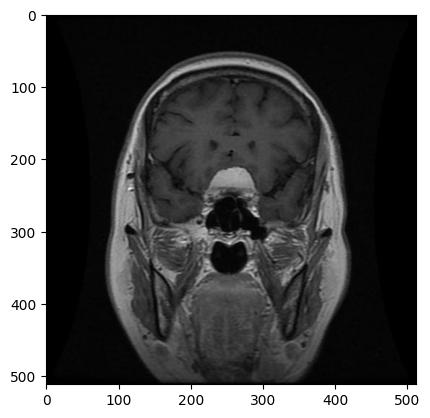

In [93]:
plt.imshow(img)

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(18).jpg 0


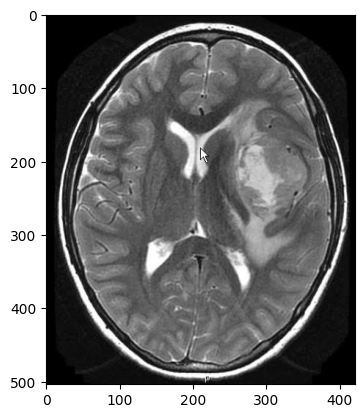

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(26).jpg 0


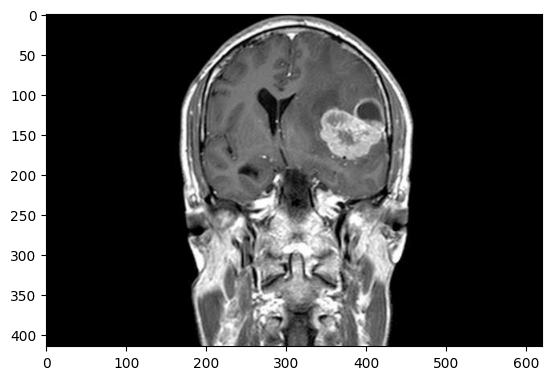

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(28).jpg 0


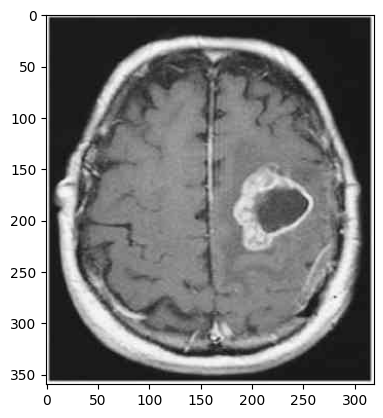

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(29).jpg 0


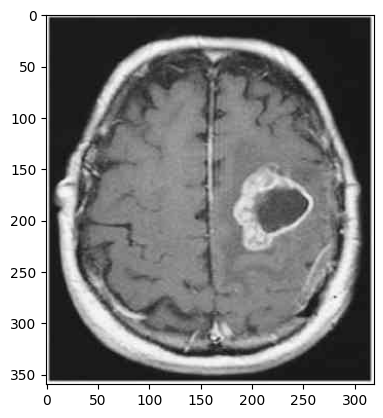

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(37).jpg 0


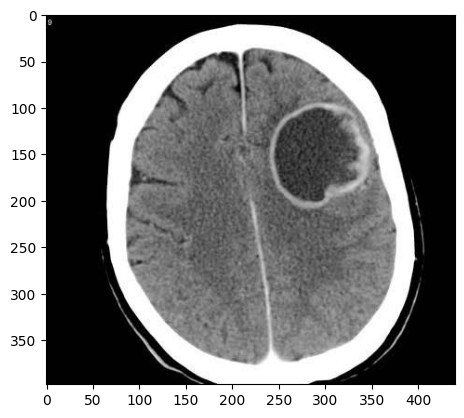

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(48).jpg 0


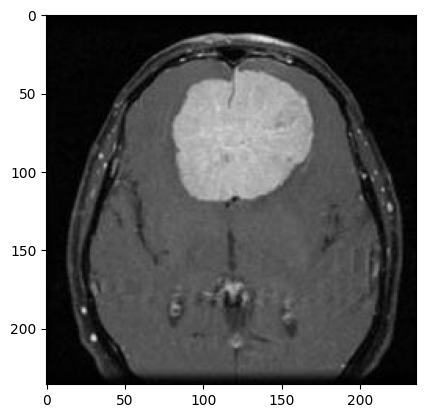

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(5).jpg 0


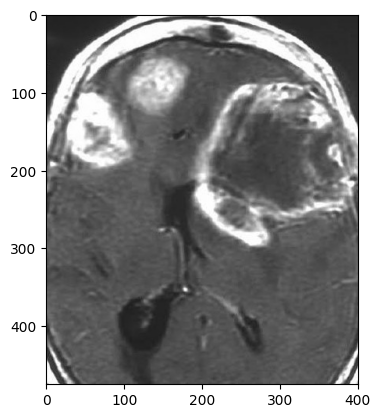

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(79).jpg 0


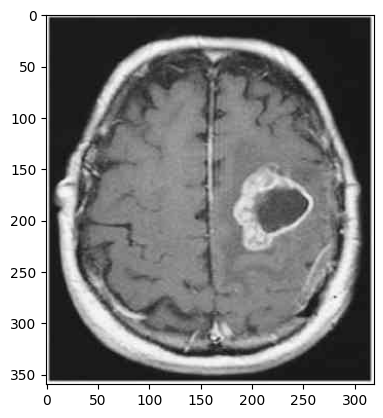

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(82).jpg 0


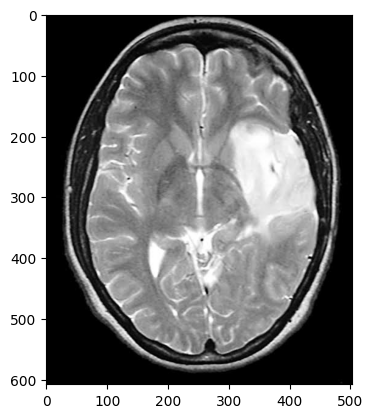

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(88).jpg 0


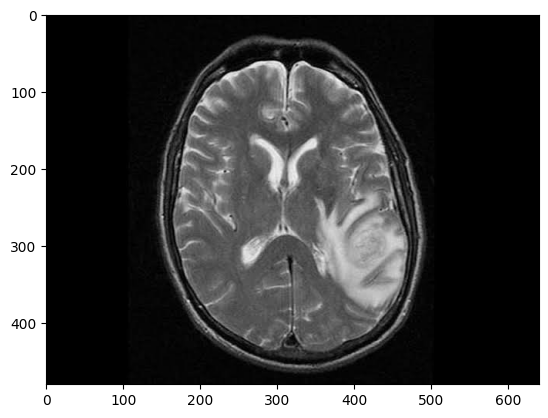

./Brain-Tumor-Classification-DataSet/Testing/glioma_tumor/image(97).jpg 0


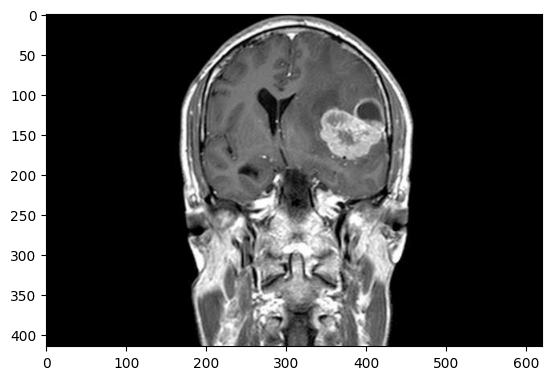

./Brain-Tumor-Classification-DataSet/Testing/meningioma_tumor/image(98).jpg 1


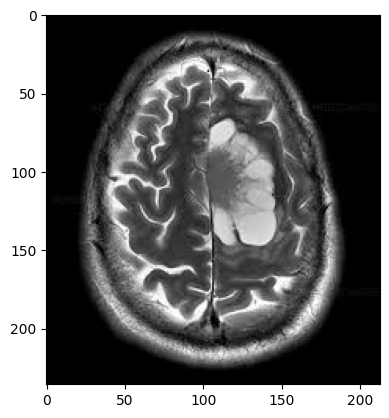

./Brain-Tumor-Classification-DataSet/Testing/pituitary_tumor/image(81).jpg 3


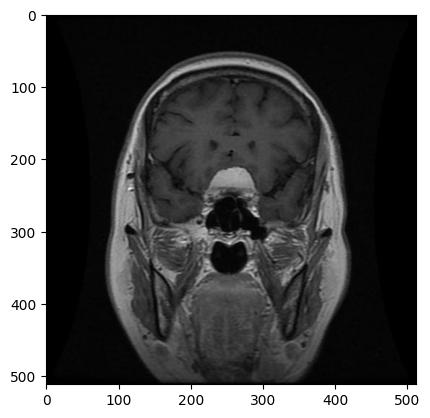

./Brain-Tumor-Classification-DataSet/Testing/pituitary_tumor/image(82).jpg 3


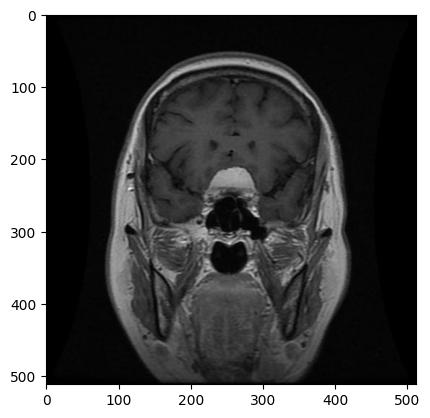

In [94]:
for path,label in mismatched_images:
    print(path, label)
    img = Image.open(path)
    plt.imshow(img)
    plt.show()

In [57]:
# Validate
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

conf_mat = confusion_matrix(all_labels, all_predictions)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

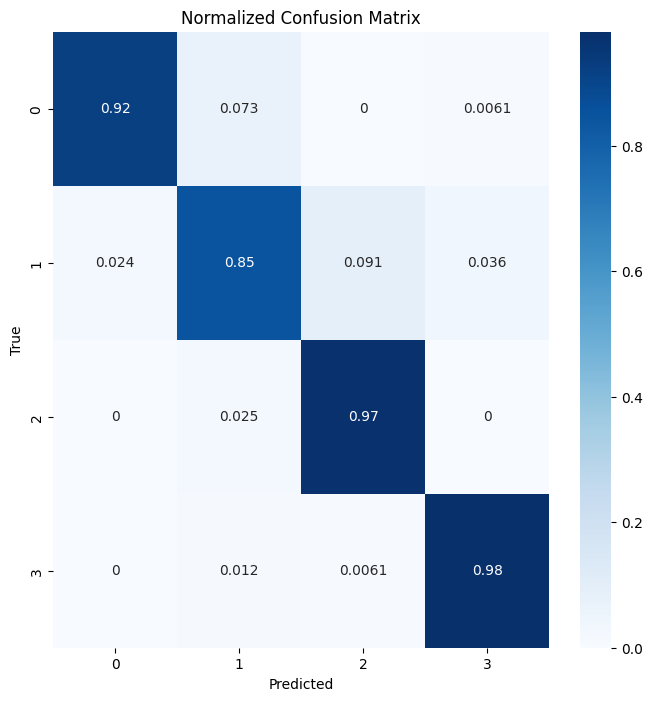

In [58]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [65]:
# 전체 훈련 횟수 설정
num_epochs = 50
# 최고 검증 정확도 초기화
best_val_acc = 0.0
# 얼리 스타핑을 위한 조건 설정 (성능 향상이 없을 때 몇 에포크까지 기다릴지)
patience = 5
# 연속적으로 성능 향상이 없는 에포크 수를 추적
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 정해진 훈련 횟수만큼 반복
for epoch in range(num_epochs):

    model.train() # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

     # 훈련 데이터 로더를 통해 배치를 반복
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # 이전 반복에서 계산된 그래디언트를 초기화
        outputs = model(inputs) # 모델에 입력을 전달하여 출력을 계산
        loss = criterion(outputs, labels) # 손실 함수를 사용하여 손실 계산
        loss.backward() # 손실에 대한 그래디언트를 계산
        optimizer.step() # 옵티마이저를 사용하여 모델의 가중치를 업데이트

        running_loss += loss.item()  # 총 손실을 누적

        _, predicted = torch.max(outputs.data, 1) # 예측 결과 계산
        total_train += labels.size(0) # 전체 레이블 수 업데이트
        correct_train += (predicted == labels).sum().item() # 정확한 예측 수 업데이트

    # 에포크별 훈련 정확도 및 손실 계산
    train_acc = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validate
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = correct_val / total_val
    val_loss = running_val_loss / len(valid_loader)

    # 손실 기록
    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # 최고 검증 정확도를 갱신하고 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_after.pth')
        no_improve = 0
    else:
        no_improve += 1 # 성능 향상이 없으면 no_improve 카운터 증가
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break

print('Finished Training')

Epoch 1/50: 100%|██████████| 9/9 [00:16<00:00,  1.79s/it]


Train Loss: 0.0644, Train Accuracy: 0.9983, Validation Loss: 0.2798, Validation Accuracy: 0.9216


Epoch 2/50: 100%|██████████| 9/9 [00:14<00:00,  1.59s/it]


Train Loss: 0.0591, Train Accuracy: 0.9970, Validation Loss: 0.2751, Validation Accuracy: 0.9233


Epoch 3/50: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


Train Loss: 0.0555, Train Accuracy: 0.9978, Validation Loss: 0.2716, Validation Accuracy: 0.9233


Epoch 4/50: 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


Train Loss: 0.0492, Train Accuracy: 0.9991, Validation Loss: 0.2680, Validation Accuracy: 0.9233


Epoch 5/50: 100%|██████████| 9/9 [00:13<00:00,  1.51s/it]


Train Loss: 0.0454, Train Accuracy: 0.9996, Validation Loss: 0.2662, Validation Accuracy: 0.9233


Epoch 6/50: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]


Train Loss: 0.0424, Train Accuracy: 0.9996, Validation Loss: 0.2631, Validation Accuracy: 0.9233


Epoch 7/50: 100%|██████████| 9/9 [00:14<00:00,  1.65s/it]


Train Loss: 0.0387, Train Accuracy: 0.9996, Validation Loss: 0.2592, Validation Accuracy: 0.9233
Early stopping
Finished Training


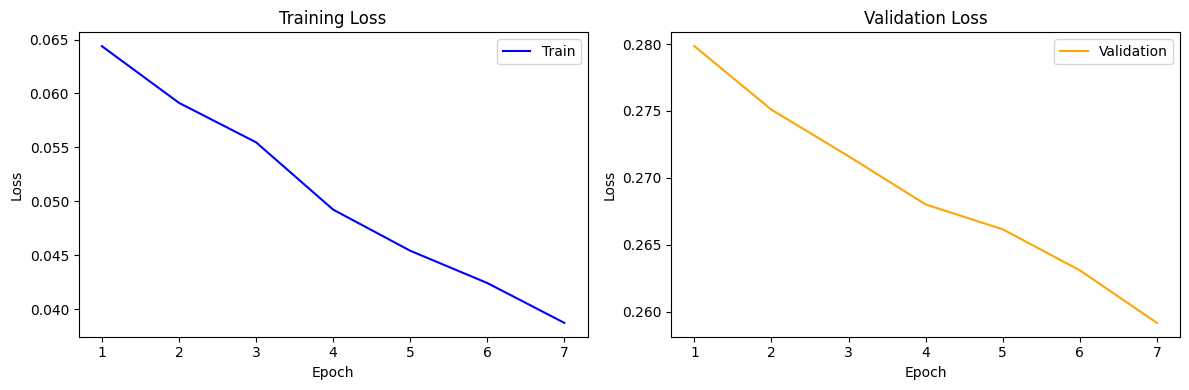

In [66]:
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Loss 그래프
axes[0].plot(range(1, actual_epochs + 1), train_losses, label='Train', color='blue')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()

# Validation Loss 그래프
axes[1].plot(range(1, actual_epochs + 1), valid_losses, label='Validation', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()